## 목적
- 최대한 깔끔하고 이해 가능한 모델 만들기

## model list
1. multi class: 제조사 / 가격대
2. binary class: 노트 / 태블릿 / flagship 선호
3. future: 최신

## Pacakage

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import time
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta
from datetime import datetime

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
MODEL_PATH = '/home/dmig/work/dominic_workspace/model/'

## load data

In [12]:
df_merge = pd.read_pickle(os.path.join(DATA_PATH, 'clean_merge.pkl'))
df_meta = pd.read_pickle(os.path.join(DATA_PATH, 'clean_meta.pkl'))

df_merge.shape, df_meta.shape

((1511955, 416), (1621, 15))

In [13]:
## save label encoder
with open(os.path.join(DATA_PATH, 'clean_le_dict.pkl'), 'rb') as f:
    le_dict = pickle.load(f)

## data split

In [14]:
df_merge.shape

(1511955, 416)

In [23]:
df_merge['label_price_range'] = df_merge['label_out_prc'].apply(lambda x: 1400000 if x > 1400000 else x)
df_merge['label_price_range'] = pd.cut(df_merge['label_price_range'], bins=np.arange(0,1400001, 200000), labels=np.arange(0,7))

In [53]:
# data
df_trn = df_merge[df_merge['ym'].isin(['201902', '201903', '201904', '201905'])]
df_val = df_merge[df_merge['ym']=='201906']
df_tst = df_merge[df_merge['ym']=='201907']

df_trn.shape, df_val.shape, df_tst.shape

((920573, 417), (254853, 417), (336529, 417))

In [54]:
df_list = [df_trn, df_val, df_tst]

In [55]:
label_cols = [c for c in df_trn.columns if 'label_' in c]

idx_col = 'svc_mgmt_num'
target_cols = ['label_mfact_nm', 'label_price_range', 'label_tablet_yn', 'label_note_yn', 'label_flagship_yn']

feature_cols = [c for c in df_trn.columns if c not in [idx_col, 'ym', 'next_ym'] + label_cols ]

In [59]:
feature_cols

['sex_cd',
 'age',
 'real_avg_arpu',
 'roaming_cnt_m3',
 'last_eqp_buy_duration',
 'tw_visit_days_fee_t_small',
 'location_weekday_visit_dong',
 'mbr_discount_cnt_convenience_store',
 'mbr_discount_amt_family_restaurant',
 'mbr_discount_amt_shopping',
 'tw_visit_days_fee_t_essence',
 'mbr_discount_amt_convenience_store',
 'additional_svc_oksusu_scrb_type',
 'data_gift_recv_yn_bf_m2',
 'mbr_discount_cnt_shopping',
 'mbr_use_cnt',
 'avg_eqp_buy_duration',
 'avg_chg_duration',
 'tw_visit_days_vas_internet',
 'mbr_discount_cnt_video',
 'tw_visit_days_vas_number_plus',
 'eqp_chg_period',
 'fee_chg_cnt',
 'twld_fee_visit_cnt_bf_m2',
 'data_usage_in_gb_bf_m2',
 'twld_visit_cnt_bf_m1',
 'tw_visit_days_fee_senior_12g',
 'bf_m3_data_over_usage_cnt',
 'eqp_out_prc',
 'real_arpu_bf_m1',
 'tw_visit_days_benefit',
 'filter_sex',
 'copn_data_u1_yn_bf_m0',
 'bas_fee_amt',
 'day_traffic_hour_ratio',
 'channel',
 'tw_visit_days_remained_data',
 'tw_visit_days_vas_call_keeper',
 'mbr_discount_amt_food_and_beverage',
 'tw_visit_days_fee_t_large',
 'filter_block_obj_cl_cd',
 't_agr_t_eqpal_scrb_mth_cnt',
 'mth_cnsl_cnt_bf_m2',
 'twld_fee_visit_cnt_bf_m1',
 'bf_m6_data_over_usage_cnt',
 'location_weekend_visit_gu',
 'tw_visit_days_wire_prod_list',
 'mbr_discount_amt_theme_park',
 'op_sale_chnl_cl_cd',
 'twld_visit_cnt_bf_m0',
 'avg_subscription_period',
 'sml_pay_cnt_bf_m2',
 'smartwatch_yn',
 'ref_data_usage_in_gb_bf_m2',
 'sml_pay_amt_bf_m1',
 'filter_fee_prod',
 'bf_m3_fee_chg_cnt',
 'simpl_ref_cnsl_cnt_bf_m0',
 'tw_visit_days_my_vas',
 'othr_co_icall_call',
 'mbr_discount_amt_mobile_and_media',
 'tw_visit_days_unbill',
 'copn_left_cnt_bf1',
 'avg_twld_visit_cnt',
 'allot_prn_amt',
 'fee_chg_period',
 'additional_svc_allcare_scrb_type',
 'mbr_discount_cnt_coffee',
 'prod_nm',
 'additional_svc_ansim_option_scrb_type',
 'nh00000059_yn',
 'tw_visit_days_my_fee',
 'mbr_discount_amt_11st',
 'tw_visit_days_vas_internet_family_comb',
 'data_gift_send_yn_bf_m0',
 'real_arpu_bf_m2',
 'filter_pps',
 'job_cd',
 'data_usage_in_gb_bf_m1',
 'tw_visit_days_vas_list',
 'filter_smile',
 'copn_data_u1_yn_bf_m1',
 'copn_left_cnt_bf2',
 'tw_visit_days_fee_t_infinity',
 'filter_svc_st_cd',
 'childwatch_yn',
 'family_marriage_yn',
 'tw_visit_days_vas_pooq',
 'overage_bf2',
 'voc_rcv_prtn_cnt_bf_m1',
 'tw_visit_days_fee_0_large',
 'twld_visit_cnt_bf_m2',
 'filter_svc_use_typ_cd',
 'pmth_inv_bamt',
 'sml_pay_amt_bf_m2',
 'mbr_card_gr_cd',
 'tablet_yn',
 'location_weekday_visit_city',
 'mbr_discount_amt_movie',
 'family_comb_duration',
 'dsat_cnsl_cnt_bf_m2',
 'mbr_discount_amt_sports',
 'filter_lte',
 'dcb_cnt_bf_m0',
 'additional_svc_flo_scrb_type',
 'location_weekend_visit_city',
 'na00002040_yn',
 'mbr_discount_amt_beauty_and_fashion',
 'mbr_discount_amt_bakery',
 'tw_visit_days_fee_senior_save',
 'mbr_discount_amt_chocolate',
 'location_weekend_visit_dong',
 'bf_m6_data_usage_ratio_avg',
 'dcb_amt_bf_m2',
 'mbr_discount_amt_pizza',
 'svc_gr_cd',
 'mbr_use_discount_amt',
 'tw_visit_days_tfamilymoa',
 'family_yn',
 'voc_snd_prtn_cnt_bf_m1',
 'bf_m6_avg_data_usage_in_gb',
 'mbr_discount_cnt_sports',
 'tw_visit_days_vas_terminate',
 'filter_tfamilymoa',
 'data_usage_in_gb_bf_m5',
 'tw_spd_chk_1m',
 'nh00000037_yn',
 'tw_visit_days_realtime_bill',
 'tw_visit_days_fee_t_ansim_4g',
 'tw_visit_days_vas_my_smartcall',
 'tw_visit_days_fee_t_save',
 'filter_usim_indpnd_svc',
 'tw_visit_days_fee_t_max',
 'real_data_use_gb_bf_m0',
 'night_traffic_hour_ratio',
 'tw_visit_days_vas_call_available',
 'mbr_discount_cnt_chocolate',
 'tw_visit_days_fee_t_ansim_25g',
 'mng_nice_cb_scr',
 'additional_svc_melon_scrb_type',
 'card_pay_cnt_bf_m1',
 'voc_snd_prtn_cnt_bf_m2',
 'nh00000084_yn',
 'skt_icall_call',
 'cmpgn_succ_cnt_m3',
 'family_rep_yn',
 'last_display_resol',
 'dcb_amt_bf_m1',
 'data_usage_in_gb_bf_m0',
 'tw_visit_days_suspend',
 'family_child_yn',
 'night_traffic_mb',
 'tw_visit_days_roaming_list',
 'mbr_discount_cnt_jeju',
 'tw_visit_days_vas_coloring',
 'mbr_discount_cnt_tr

In [60]:
len(feature_cols)

400

In [61]:
target_cols

['label_mfact_nm',
 'label_price_range',
 'label_tablet_yn',
 'label_note_yn',
 'label_flagship_yn']

In [65]:
label_dict = {
    'label_price_range': 'multi',
    'label_mfact_nm': 'multi',
    'label_tablet_yn': 'binary',
    'label_note_yn': 'binary',
    'label_flagship_yn': 'binary',
}

In [66]:
def lgb_train(params, train_set, valid_sets):
    t1 = time.time()
    clf = lgb.train(lgb_params,
                    train_set=lgb_trn,
                    valid_sets=[lgb_trn, lgb_val],
                    num_boost_round=2000,
                    early_stopping_rounds=100,
                    verbose_eval=50)
    print('elapsed time:', time.time()-t1)
    return clf

In [68]:
clf_dict = {}

for label in target_cols:
    print('='*50)
    print('label: ', label)
    
    # input
    lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[label], feature_name=feature_cols)
    lgb_val = lgb.Dataset(df_val[feature_cols], df_val[label], feature_name=feature_cols)
    
    # problem type
    p_type = label_dict[label]
    print('p_type: ', p_type)
    
    # params
    lgb_params = {
        'boosting_type': 'dart',
        'num_leaves': 32,
        'learning_rate': 0.05,
        'num_threads': 40,
    }
    

    # train
    if p_type=='multi':
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = df_trn[label].nunique()
        lgb_params['metric'] = 'multi_logloss'
        
    elif p_type=='binary':
        lgb_params['objective'] = 'binary'
        lgb_params['metric'] = 'auc'
        lgb_params['is_unbalance'] = True
        
    else:
        print('ERROR!')
        
    clf = lgb_train(lgb_params, lgb_trn, [lgb_trn, lgb_val])

    clf_dict[label] = clf
    print('')

label:  label_mfact_nm
p_type:  multi
[50]	training's multi_logloss: 0.526358	valid_1's multi_logloss: 0.546234
[100]	training's multi_logloss: 0.533294	valid_1's multi_logloss: 0.560626
[150]	training's multi_logloss: 0.527358	valid_1's multi_logloss: 0.556634
[200]	training's multi_logloss: 0.505584	valid_1's multi_logloss: 0.535111
[250]	training's multi_logloss: 0.491955	valid_1's multi_logloss: 0.522416
[300]	training's multi_logloss: 0.480411	valid_1's multi_logloss: 0.511703
[350]	training's multi_logloss: 0.476176	valid_1's multi_logloss: 0.508344
[400]	training's multi_logloss: 0.467286	valid_1's multi_logloss: 0.500688
[450]	training's multi_logloss: 0.461108	valid_1's multi_logloss: 0.496552
[500]	training's multi_logloss: 0.457611	valid_1's multi_logloss: 0.494015
[550]	training's multi_logloss: 0.454809	valid_1's multi_logloss: 0.492366
[600]	training's multi_logloss: 0.455272	valid_1's multi_logloss: 0.492828
[650]	training's multi_logloss: 0.452212	valid_1's multi_loglos

### feature importance

In [69]:
for label, clf in clf_dict.items():
    df_fea = pd.DataFrame({
        'feature': clf.feature_name(),
        'importance': clf.feature_importance()
    }).sort_values('importance', ascending=False).head(20)
    print('='*50)
    print('label: ', label)
    display(df_fea)
    print('')

label:  label_mfact_nm


feature  importance
2               real_avg_arpu       18298
1                         age       17300
209               voc_srv_cnt       15657
28                eqp_out_prc        7487
29            real_arpu_bf_m1        6850
398     days_from_eqp_acqr_dt        6805
59         othr_co_icall_call        6675
4       last_eqp_buy_duration        6632
388                  mfact_nm        5859
292     app_use_traffic_insta        5554
322  app_use_traffic_facebook        4485
0                      sex_cd        4432
387                eqp_pet_nm        4348
399         days_from_mktg_dt        4199
143            skt_icall_call        4164
262         avg_display_resol        3859
75            real_arpu_bf_m2        3640
48         op_sale_chnl_cl_cd        3467
385            rep_eqp_mdl_cd        3243
395     days_from_svc_scrb_dt        3054


label:  label_price_range


feature  importance
2            real_avg_arpu       48516
209            voc_srv_cnt       23554
1                      age       21979
29         real_arpu_bf_m1       18475
4    last_eqp_buy_duration       16491
387             eqp_pet_nm       14072
28             eqp_out_prc       13105
398  days_from_eqp_acqr_dt       12167
75         real_arpu_bf_m2       10963
399      days_from_mktg_dt       10287
260        real_arpu_bf_m3        7856
385         rep_eqp_mdl_cd        6930
59      othr_co_icall_call        6808
394           eqp_mdl_size        6276
386             eqp_nm_rmk        5982
388               mfact_nm        5884
64           allot_prn_amt        5549
65          fee_chg_period        5150
262      avg_display_resol        4788
183      max_display_resol        4715


label:  label_tablet_yn


feature  importance
138              mng_nice_cb_scr        3528
398        days_from_eqp_acqr_dt        2291
78        data_usage_in_gb_bf_m1        1263
2                  real_avg_arpu        1123
163       real_data_use_gb_bf_m1        1116
1                            age         969
399            days_from_mktg_dt         937
260              real_arpu_bf_m3         936
50       avg_subscription_period         912
348             app_use_cnt_game         908
75               real_arpu_bf_m2         906
29               real_arpu_bf_m1         899
215         avg_data_usage_in_gb         768
6    location_weekday_visit_dong         754
133       real_data_use_gb_bf_m0         729
16          avg_eqp_buy_duration         714
34        day_traffic_hour_ratio         698
209                  voc_srv_cnt         683
214       real_data_use_gb_bf_m2         675
124       data_usage_in_gb_bf_m5         670


label:  label_note_yn


feature  importance
2               real_avg_arpu        7421
28                eqp_out_prc        2904
4       last_eqp_buy_duration        2492
387                eqp_pet_nm        2401
29            real_arpu_bf_m1        2356
1                         age        2112
209               voc_srv_cnt        2008
260           real_arpu_bf_m3        1461
75            real_arpu_bf_m2        1430
390                   note_yn        1402
59         othr_co_icall_call        1398
143            skt_icall_call        1362
398     days_from_eqp_acqr_dt        1138
385            rep_eqp_mdl_cd         957
292     app_use_traffic_insta         941
399         days_from_mktg_dt         921
65             fee_chg_period         889
33                bas_fee_amt         798
322  app_use_traffic_facebook         598
257     t_agr_t_eqpal_scrb_ym         591


label:  label_flagship_yn


feature  importance
2               real_avg_arpu        9245
1                         age        4551
29            real_arpu_bf_m1        4072
209               voc_srv_cnt        3235
75            real_arpu_bf_m2        2633
260           real_arpu_bf_m3        2579
399         days_from_mktg_dt        2207
4       last_eqp_buy_duration        1851
387                eqp_pet_nm        1501
398     days_from_eqp_acqr_dt        1363
388                  mfact_nm        1227
59         othr_co_icall_call        1171
262         avg_display_resol        1079
393               flagship_yn        1061
33                bas_fee_amt        1057
322  app_use_traffic_facebook         879
143            skt_icall_call         775
385            rep_eqp_mdl_cd         767
64              allot_prn_amt         688
292     app_use_traffic_insta         680

In [70]:
from sm_utils import evaluate

In [71]:
label = 'label_flagship_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.818185  0.796098   0.946087  0.864636  0.919694
         pred: 1  pred: 0
true: 1   147985    37903
true: 0     8433    60532


In [72]:
label = 'label_note_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.882054  0.428993   0.228636  0.298294  0.787867
         pred: 1  pred: 0
true: 1     6389     8504
true: 0    21555   218405


        acc    recall  precision  f1_score       auc
0  0.983971  0.787356   0.032736  0.062858  0.885731
         pred: 1  pred: 0
true: 1      137       37
true: 0     4048   250631


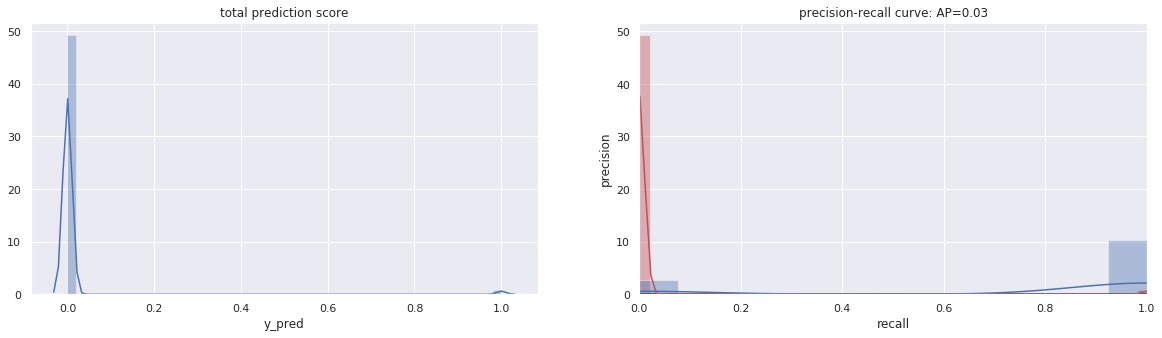

In [73]:
label = 'label_tablet_yn'
a = evaluate(df_val[feature_cols], df_val[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.826684  0.821035   0.953808  0.882455  0.914358
         pred: 1  pred: 0
true: 1   218938    47723
true: 0    10603    59265


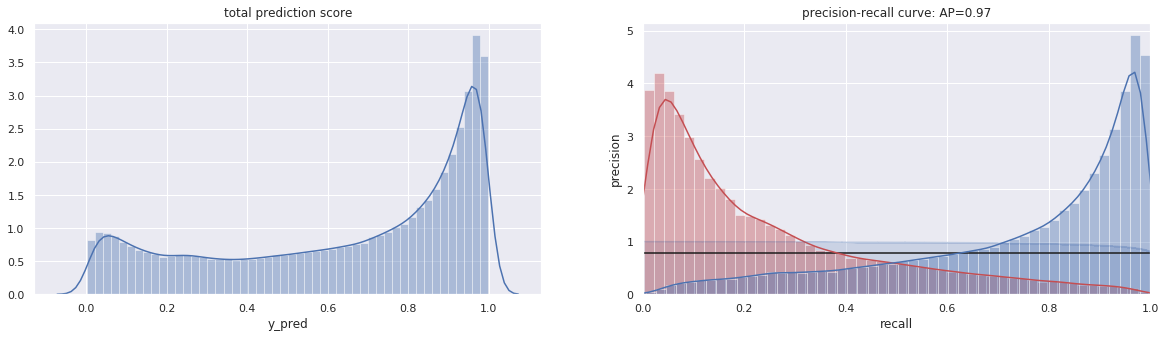

In [74]:
label = 'label_flagship_yn'
a = evaluate(df_tst[feature_cols], df_tst[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.554113  0.353714   0.692954  0.468357  0.611756
         pred: 1  pred: 0
true: 1    66096   120767
true: 0    29287   120379


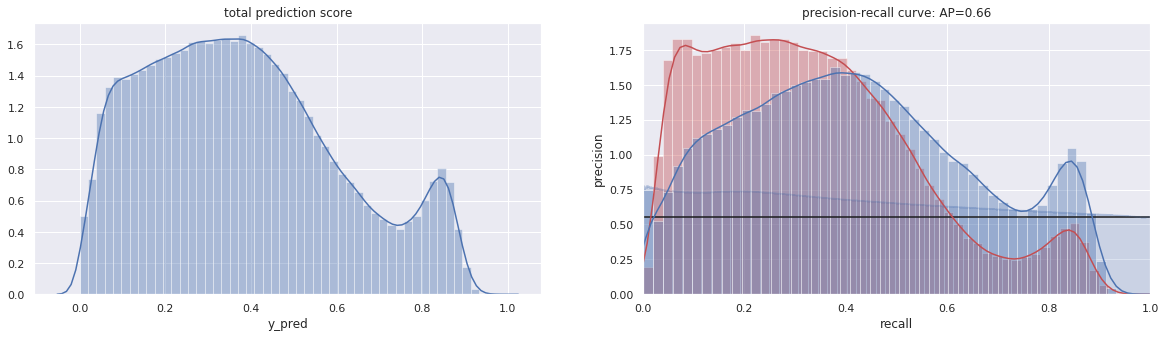

In [75]:
label = 'label_note_yn'
a = evaluate(df_tst[feature_cols], df_tst[label], clf_dict[label], clf_name='lgb' )

        acc    recall  precision  f1_score       auc
0  0.986135  0.901024   0.053867  0.101656  0.943616
         pred: 1  pred: 0
true: 1      264       29
true: 0     4637   331599


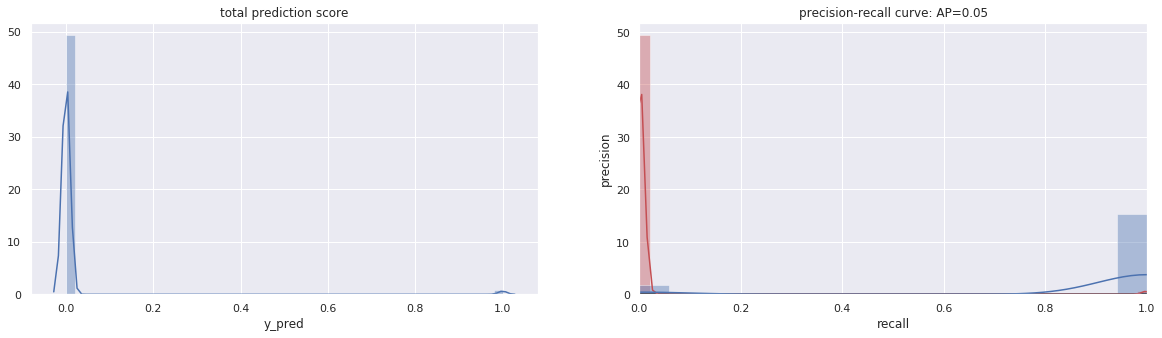

In [76]:
label = 'label_tablet_yn'
a = evaluate(df_tst[feature_cols], df_tst[label], clf_dict[label], clf_name='lgb' )

In [83]:
clf_dict

{'label_mfact_nm': <lightgbm.basic.Booster at 0x7f87a81ec550>,
 'label_price_range': <lightgbm.basic.Booster at 0x7f87a55db4e0>,
 'label_tablet_yn': <lightgbm.basic.Booster at 0x7f87a55dbf60>,
 'label_note_yn': <lightgbm.basic.Booster at 0x7f8720379710>,
 'label_flagship_yn': <lightgbm.basic.Booster at 0x7f87a55100b8>}